In [2]:
!pip install livelossplot

In [3]:
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from livelossplot import PlotLossesKeras

<function matplotlib.pyplot.show>

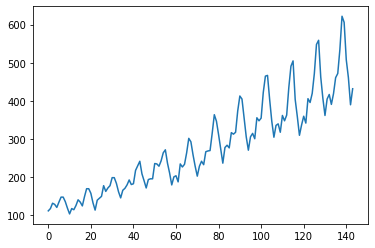

In [5]:
dataframe = pd.read_csv('/content/drive/MyDrive/Neural Network/dataset/airline-passengers.csv',usecols=[1],engine='python')
plt.plot(dataframe)
plt.show

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#fix random
numpy.random.seed(7)

In [7]:
#load data
dataset = dataframe.values
dataset = dataset.astype('float32')
display(dataframe.head())

,Passengers
0,112
1,118
2,132
3,129
4,121


In [8]:
#normalize the dataset
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

In [9]:
#split into train and test sets
train_size = int(len(dataset)*0.67)
test_size = len(dataset) - train_size
train,test = dataset[0:train_size,:],dataset[train_size:len(dataset),:]
print('banyak data train: ',len(train),'banyak data test: ',len(test))

banyak data train:  96 banyak data test:  48


In [10]:
#convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX,dataY = [],[]
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back),0]
        dataX.append(a)
        dataY.append(dataset[i+look_back,0])
    return numpy.array(dataX),numpy.array(dataY)

In [11]:
#reshape into X=t and Y=t+1
look_back = 3
trainX,trainY = create_dataset(train,look_back)
testX,testY = create_dataset(test,look_back)

#display data X=t-..,t and Y=t+1
dF = numpy.zeros((trainX.shape[0],trainX.shape[1]+1))
dF[:,:-1] = trainX
dF[:,-1] = trainY
dFrame = pd.DataFrame(dF)
display(dFrame)

,0,1,2,3
0,0.015444,0.027027,0.054054,0.048263
1,0.027027,0.054054,0.048263,0.032819
2,0.054054,0.048263,0.032819,0.059846
3,0.048263,0.032819,0.059846,0.084942
4,0.032819,0.059846,0.084942,0.084942
...,...,...,...,...
87,0.403475,0.413127,0.521235,0.596525
88,0.413127,0.521235,0.596525,0.581081
89,0.521235,0.596525,0.581081,0.484556
90,0.596525,0.581081,0.484556,0.389961


In [12]:
#reshape input to be [sample,time steps, features]
trainX = numpy.reshape(trainX,(trainX.shape[0],1,trainX.shape[1]))
testX = numpy.reshape(testX,(testX.shape[0],1,testX.shape[1]))

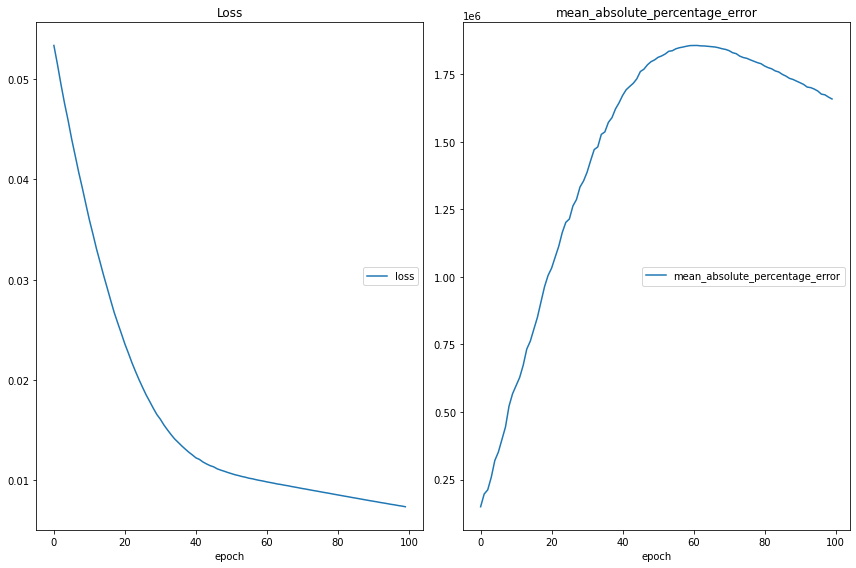

Loss
	loss             	 (min:    0.007, max:    0.053, cur:    0.007)
mean_absolute_percentage_error
	mean_absolute_percentage_error 	 (min: 149374.203, max: 1856113.375, cur: 1658074.250)


In [13]:
#create and fit the LSTM Network
model = Sequential()
model.add(layers.GRU(4,input_shape=(trainX.shape[0],look_back)))
model.add(layers.Dense(1))
model.compile(loss='mean_squared_error', metrics=['mean_absolute_percentage_error'], optimizer='adam')
model.fit(trainX,trainY, epochs=10, callbacks=[PlotLossesKeras()],verbose=2)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4)                 128       
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 133
Trainable params: 133
Non-trainable params: 0
_________________________________________________________________


In [15]:
weights = model.get_weights()

In [16]:
#make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
#invert predictions
trainPredict_i = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict_i = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
#calculate RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0],trainPredict_i[:,0]))
print('Train Score: %.2f RMSE'%(trainScore))
testScore = math.sqrt(mean_squared_error(testY[0],testPredict_i[:,0]))
print('Train Score: %.2f RMSE'%(testScore))

Train Score: 44.36 RMSE
Train Score: 128.79 RMSE


<function matplotlib.pyplot.show>

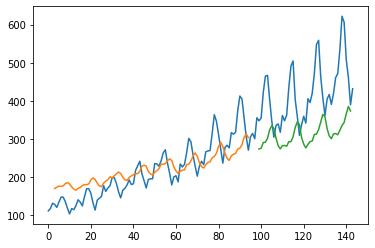

In [17]:
#shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:,:] = numpy.nan
trainPredictPlot[look_back:len(trainPredict_i)+look_back,:] = trainPredict_i
#shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:,:] = numpy.nan
testPredictPlot[len(trainPredict_i)+(look_back)*2+1:len(dataset)-1,:] = testPredict_i
#plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show